In [1]:
# import os 
from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import lightning.pytorch as pl
import torch
import hydra
import numpy as np  
from hydra import compose, initialize
from omegaconf import OmegaConf,DictConfig
import datetime
import matplotlib.pyplot as plt
import xarray as xr
from celluloid import Camera
import datetime
import subprocess
import sys
import os
from hydra import compose, initialize
from omegaconf import OmegaConf
from evaluation.visualization import rollout
import pickle

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config",overrides=["experiment=one_month_multiple_variable_v100"])
scratch = os.environ['SCRATCH']
work = os.environ['WORK']

In [2]:
climatology_surface_means = np.load('data/climatology_surface_means.npy')
climatology_surface_stds = np.broadcast_to(np.expand_dims(np.load(f'data/climatology_surface_stds.npy'),(-2,-1)),(12,91,143,144))
just_climatology = torch.tile(torch.from_numpy(climatology_surface_means),(3,1,1,1))

In [3]:
import pickle
pkl_file = open('rollout.pickle', 'rb')

data1 = pickle.load(pkl_file)

In [10]:
test = IPSL_DCPP('test',
                 lead_time_months=1,
                 surface_variables=cfg.experiment.surface_variables,
                 depth_variables=cfg.experiment.depth_variables,
                 generate_statistics=False,
                 delta=False,
                 normalization='normal'
                )

In [11]:
#from generate_rollout import compute_rollout
#rollout_length = 24
#y = compute_rollout('9cbb1f05',True,'climatology',rollout_length)
#x = compute_rollout('edb26faa',True,'climatology',rollout_length)
#data1 = [y,x]

In [45]:
variable_name = 'gpp'
#long_name = 'Near-Surface Air Temperature'
#long_name = 'Carbon Mass in Vegetation'
long_name = 'Gross Primary Productivity'
var_index=test.surface_variables.index(variable_name)
rollout_length=36
predictions_for_plot = [[np.nanmean(x['next_state_surface'].squeeze(),axis=(-1,-2))[var_index] for x in y[0]] for y in data1]
markers = ['o','o',0,0,0,'o']
linestyles = ['dotted','dotted','dashdot','dashdot','dashdot','dotted']
colors = ['green','blue','green','blue','red','red']
markers = ['.']
labels = ['No Deltas, Normal','No Deltas,Climatology Removed','Deltas,Normal','Deltas,Climatology Removed','Deltas Spatial Norm','No Deltas Spatial Norm']

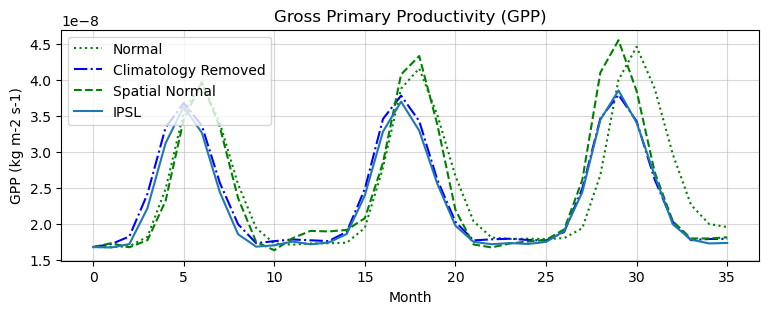

In [46]:
import xarray as xr
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

#for pred,linestyle,color,label in list(zip(predictions_for_plot,linestyles,colors,labels)):
    #plt.plot(pred,linestyle=linestyle,color=color,label=label)
no_deltas = [0,1,-1]
linestyles = ['dotted','dashdot','dashed']
labels = ['Normal','Climatology Removed','Spatial Normal']
for index in range(3):
    plt.plot(predictions_for_plot[no_deltas[index]],linestyle=linestyles[index],color=colors[index],label=labels[index])   

    
plt.plot([[np.nanmean(torch.where(x['state_constant']==1,x['next_state_surface'],np.nan).squeeze(),axis=(-1,-2))[var_index] for x in y[1]] for y in data1][1],label='IPSL')
#plt.plot([[np.nanmean(x.squeeze(),axis=(-1,-2))[var_index] for x in y[-1]] for y in data1][1],label='IPSL')
#ax.set_ylim([2, 2.8])

plt.legend()
#plt.title('Surface Temperature Rollouts, No Deltas')
plt.xlabel('Month')
#plt.ylabel('Temperature (K)')
plt.title(f'{long_name} (GPP)')
plt.xlabel('Month')
plt.grid(alpha=0.5)
#plt.ylabel('Temperature (K)')
plt.ylabel('GPP (kg m-2 s-1)')
plt.savefig(f'images/{variable_name}_without_deltas_rollout.png',transparent=True,bbox_inches='tight')

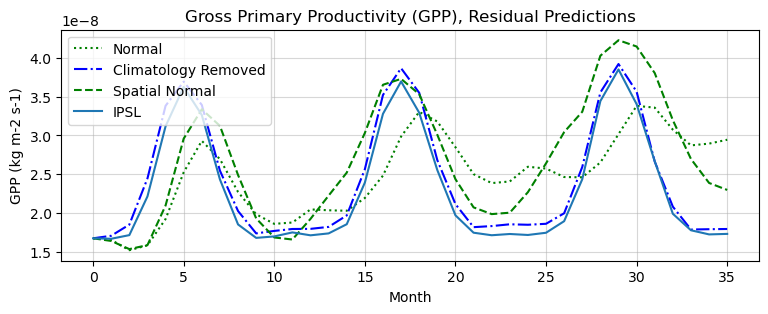

In [47]:
import xarray as xr
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

#for pred,linestyle,color,label in list(zip(predictions_for_plot,linestyles,colors,labels)):
    #plt.plot(pred,linestyle=linestyle,color=color,label=label)
deltas = [2,3,4]
#deltas = [0,1,1]
linestyles = ['dotted','dashdot','dashed']
labels = ['Normal','Climatology Removed','Spatial Normal']
for index in range(3):
    plt.plot(predictions_for_plot[deltas[index]],linestyle=linestyles[index],color=colors[index],label=labels[index])   
#ax.set_ylim([2, 2.8])

    
plt.plot([[np.nanmean(x['next_state_surface'].squeeze(),axis=(-1,-2))[var_index] for x in y[1]] for y in data1][1],label='IPSL')
plt.legend()
plt.grid(alpha=0.5)
plt.title(f'{long_name} (GPP), Residual Predictions')
plt.xlabel('Month')
#plt.ylabel('Temperature (K)')
#plt.ylabel('Carbon Mass (kg m-2)')
plt.ylabel('GPP (kg m-2 s-1)')

plt.savefig(f'images/{variable_name}_with_deltas_rollout.png',transparent=True,bbox_inches='tight')

In [48]:
#get timeseries of acc 
lat_coeffs_equi = torch.tensor([torch.cos(x) for x in torch.arange(-torch.pi/2, torch.pi/2, torch.pi/143)])
lat_coeffs_equi =  (lat_coeffs_equi/lat_coeffs_equi.mean())[None, None, None, :, None]


def acc(x, y, coeffs, dims=(-2, -1)):
   norm = (x*x).mul(coeffs).nanmean(dims)**.5
   mean_acc = (x*y).mul(coeffs).nanmean(dims) / (norm * (y*y).mul(coeffs).nanmean(dims)**.5)
   return mean_acc

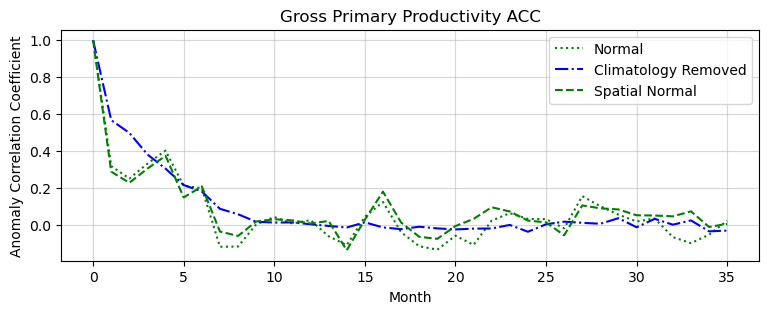

In [49]:
variable_acc_comparison = []
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

for index in range(3):
    model_acc = []
    for rollout_index in range(rollout_length):
        model_acc.append(acc(data1[no_deltas[index]][-1][rollout_index].squeeze()[var_index],data1[no_deltas[index]][-2][rollout_index].squeeze()[var_index],lat_coeffs_equi).squeeze())
    variable_acc_comparison.append(model_acc)

for pred,linestyle,color,label in list(zip(variable_acc_comparison,linestyles,colors,labels)):
    plt.plot(pred,linestyle=linestyle,color=color,label=label)

plt.xlabel('Month')
plt.legend()
plt.grid(alpha=0.5)
plt.ylabel('Anomaly Correlation Coefficient')
plt.title(f'{long_name} ACC')    
plt.savefig(f'images/{variable_name}_without_deltas_acc.png',transparent=True,bbox_inches='tight')

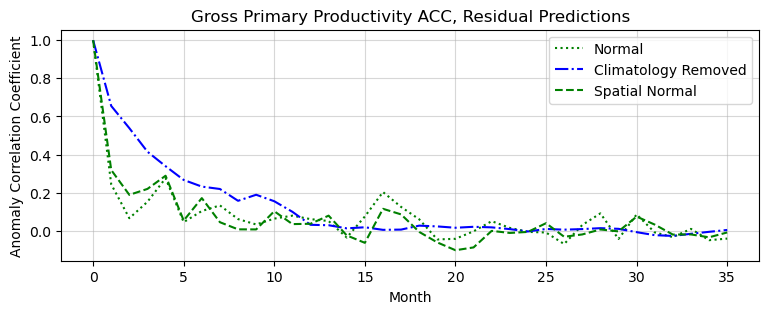

In [50]:
variable_acc_comparison = []
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

for index in range(3):
    model_acc = []
    for rollout_index in range(rollout_length):
        pred = torch.where(data1[0][1][0]['state_constant'].squeeze()==1,data1[deltas[index]][-2][rollout_index],np.nan).squeeze()[var_index]
        batch = torch.where(data1[0][1][0]['state_constant'].squeeze()==1,data1[deltas[index]][-1][rollout_index],np.nan).squeeze()[var_index]
        model_acc.append(acc(pred,batch,lat_coeffs_equi).squeeze())
    variable_acc_comparison.append(model_acc)

for pred,linestyle,color,label in list(zip(variable_acc_comparison,linestyles,colors,labels)):
    plt.plot(pred,linestyle=linestyle,color=color,label=label)

    
plt.xlabel('Month')
plt.legend()
plt.grid(alpha=0.5)
plt.ylabel('Anomaly Correlation Coefficient')
plt.title(f'{long_name} ACC, Residual Predictions')
plt.savefig(f'images/{variable_name}_with_deltas_acc.png',transparent=True,bbox_inches='tight')

In [51]:
def rmse(x, y,coeffs):
    return (torch.nanmean((x-y).mul(coeffs)**2))**.5
    

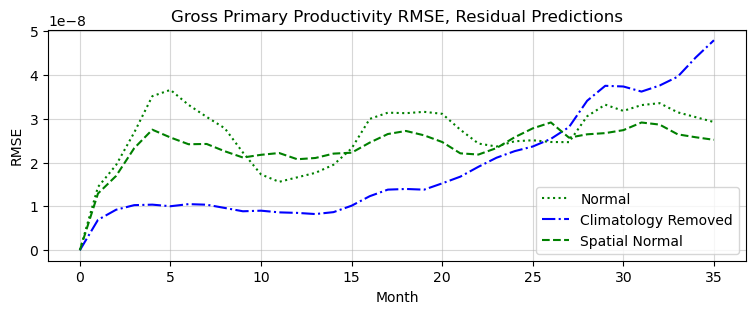

In [52]:
#calculate RMSE for rollout
variable_rmse_comparison = []
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

for index in range(3):
    model_acc = []
    for rollout_index in range(rollout_length):
        model_acc.append(rmse(data1[deltas[index]][0][rollout_index]['next_state_surface'].squeeze()[var_index],data1[deltas[index]][1][rollout_index]['next_state_surface'].squeeze()[var_index],lat_coeffs_equi.unsqueeze(1)).squeeze())
    variable_rmse_comparison.append(model_acc)
for pred,linestyle,color,label in list(zip(variable_rmse_comparison,linestyles,colors,labels)):
    plt.plot(pred,linestyle=linestyle,color=color,label=label)
plt.xlabel('Month')
plt.ylabel('RMSE')
plt.grid(alpha=0.5)

plt.legend()
plt.title(f'{long_name} RMSE, Residual Predictions')  
plt.savefig(f'images/{variable_name}_with_deltas_rmse.png',transparent=True,bbox_inches='tight')

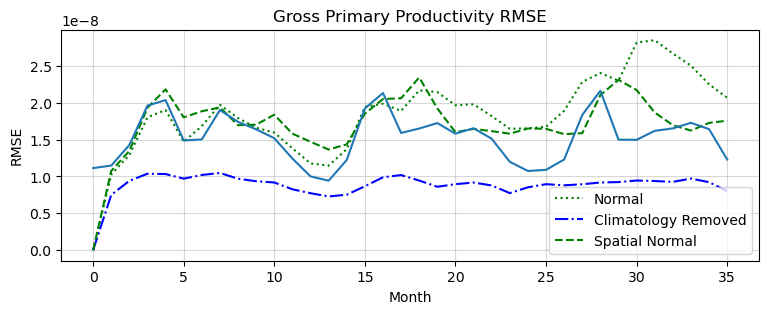

In [53]:
#calculate RMSE for rollout
variable_rmse_comparison = []
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

for index in range(3):
    model_acc = []
    for rollout_index in range(rollout_length):
        model_acc.append(rmse(data1[no_deltas[index]][0][rollout_index]['next_state_surface'].squeeze()[var_index],data1[no_deltas[index]][1][rollout_index]['next_state_surface'].squeeze()[var_index],lat_coeffs_equi.unsqueeze(1)).squeeze())
    variable_rmse_comparison.append(model_acc)
    
just_climatology_rmse = []
for rollout_index in range(rollout_length):
    just_climatology_rmse.append(rmse(just_climatology[rollout_index].squeeze()[var_index],data1[no_deltas[index]][1][rollout_index]['next_state_surface'].squeeze()[var_index],lat_coeffs_equi.unsqueeze(1)).squeeze())
 
for pred,linestyle,color,label in list(zip(variable_rmse_comparison,linestyles,colors,labels)):
    plt.plot(pred,linestyle=linestyle,color=color,label=label)
plt.plot(just_climatology_rmse)
plt.xlabel('Month')
plt.ylabel('RMSE')
plt.grid(alpha=0.5)

plt.legend()
plt.title(f'{long_name} RMSE') 
plt.savefig(f'images/{variable_name}_without_deltas_rmse.png',transparent=True,bbox_inches='tight')

In [93]:
import scipy.stats as stats

#take fourier transform put data into spectral dimension, take average of power spectra of all the powers 
def get_power_spectral_density(data):
    data = np.nan_to_num(data,0)
    #data = data[:data.shape[0], data.shape[1]//2-data.shape[0]//2:data.shape[1]//2+data.shape[0]//2]
    #have to make this square, clip the last row of lats........
   # print(data.shape)
    data = data[:,:data.shape[0]]
    npix = data.shape[0]
    #print(npix)
    #print(data.shape)
    #take the fourier image - i.e. the spectral data in the frequency domain 
    fourier_image = np.fft.fftn(data)
   # print(fourier_image.mean())
    #take the amplitudes, and one side of the fourier image (it is symmetrical)
    #why take the square here? 
 #   print(fourier_image)
    #we can find the amplitude of a sinusoidal by taking the fft and scaling it 
    #look at formula to find power from a coefficient - take abs and square https://en.wikipedia.org/wiki/Spectral_density
    fourier_amplitudes = np.abs(fourier_image)**2
    # power is just the 

    # now return Discrete Fourier Transform sample frequencies from npix... what? 
    kfreq = np.fft.fftfreq(npix) * npix # this gives the freq in hertz, need to mulptiply by "frame rate" i.e. number of pixels? 
    kfreq2D = np.meshgrid(kfreq, kfreq)
  #  print(kfreq2D[0].shape)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1]) #center each bin?
  #  print(fourier_amplitudes.shape)
  #  print(knrm.shape)
  #  print(kbins)
 #   print(knrm)
 #   print(knrm.mean())
 #   print(fourier_amplitudes)
    Abins, _, _ = stats.binned_statistic(knrm, 
                                         fourier_amplitudes,
                                         statistic = "mean",
                                         bins = kbins)
 #   print(Abins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins


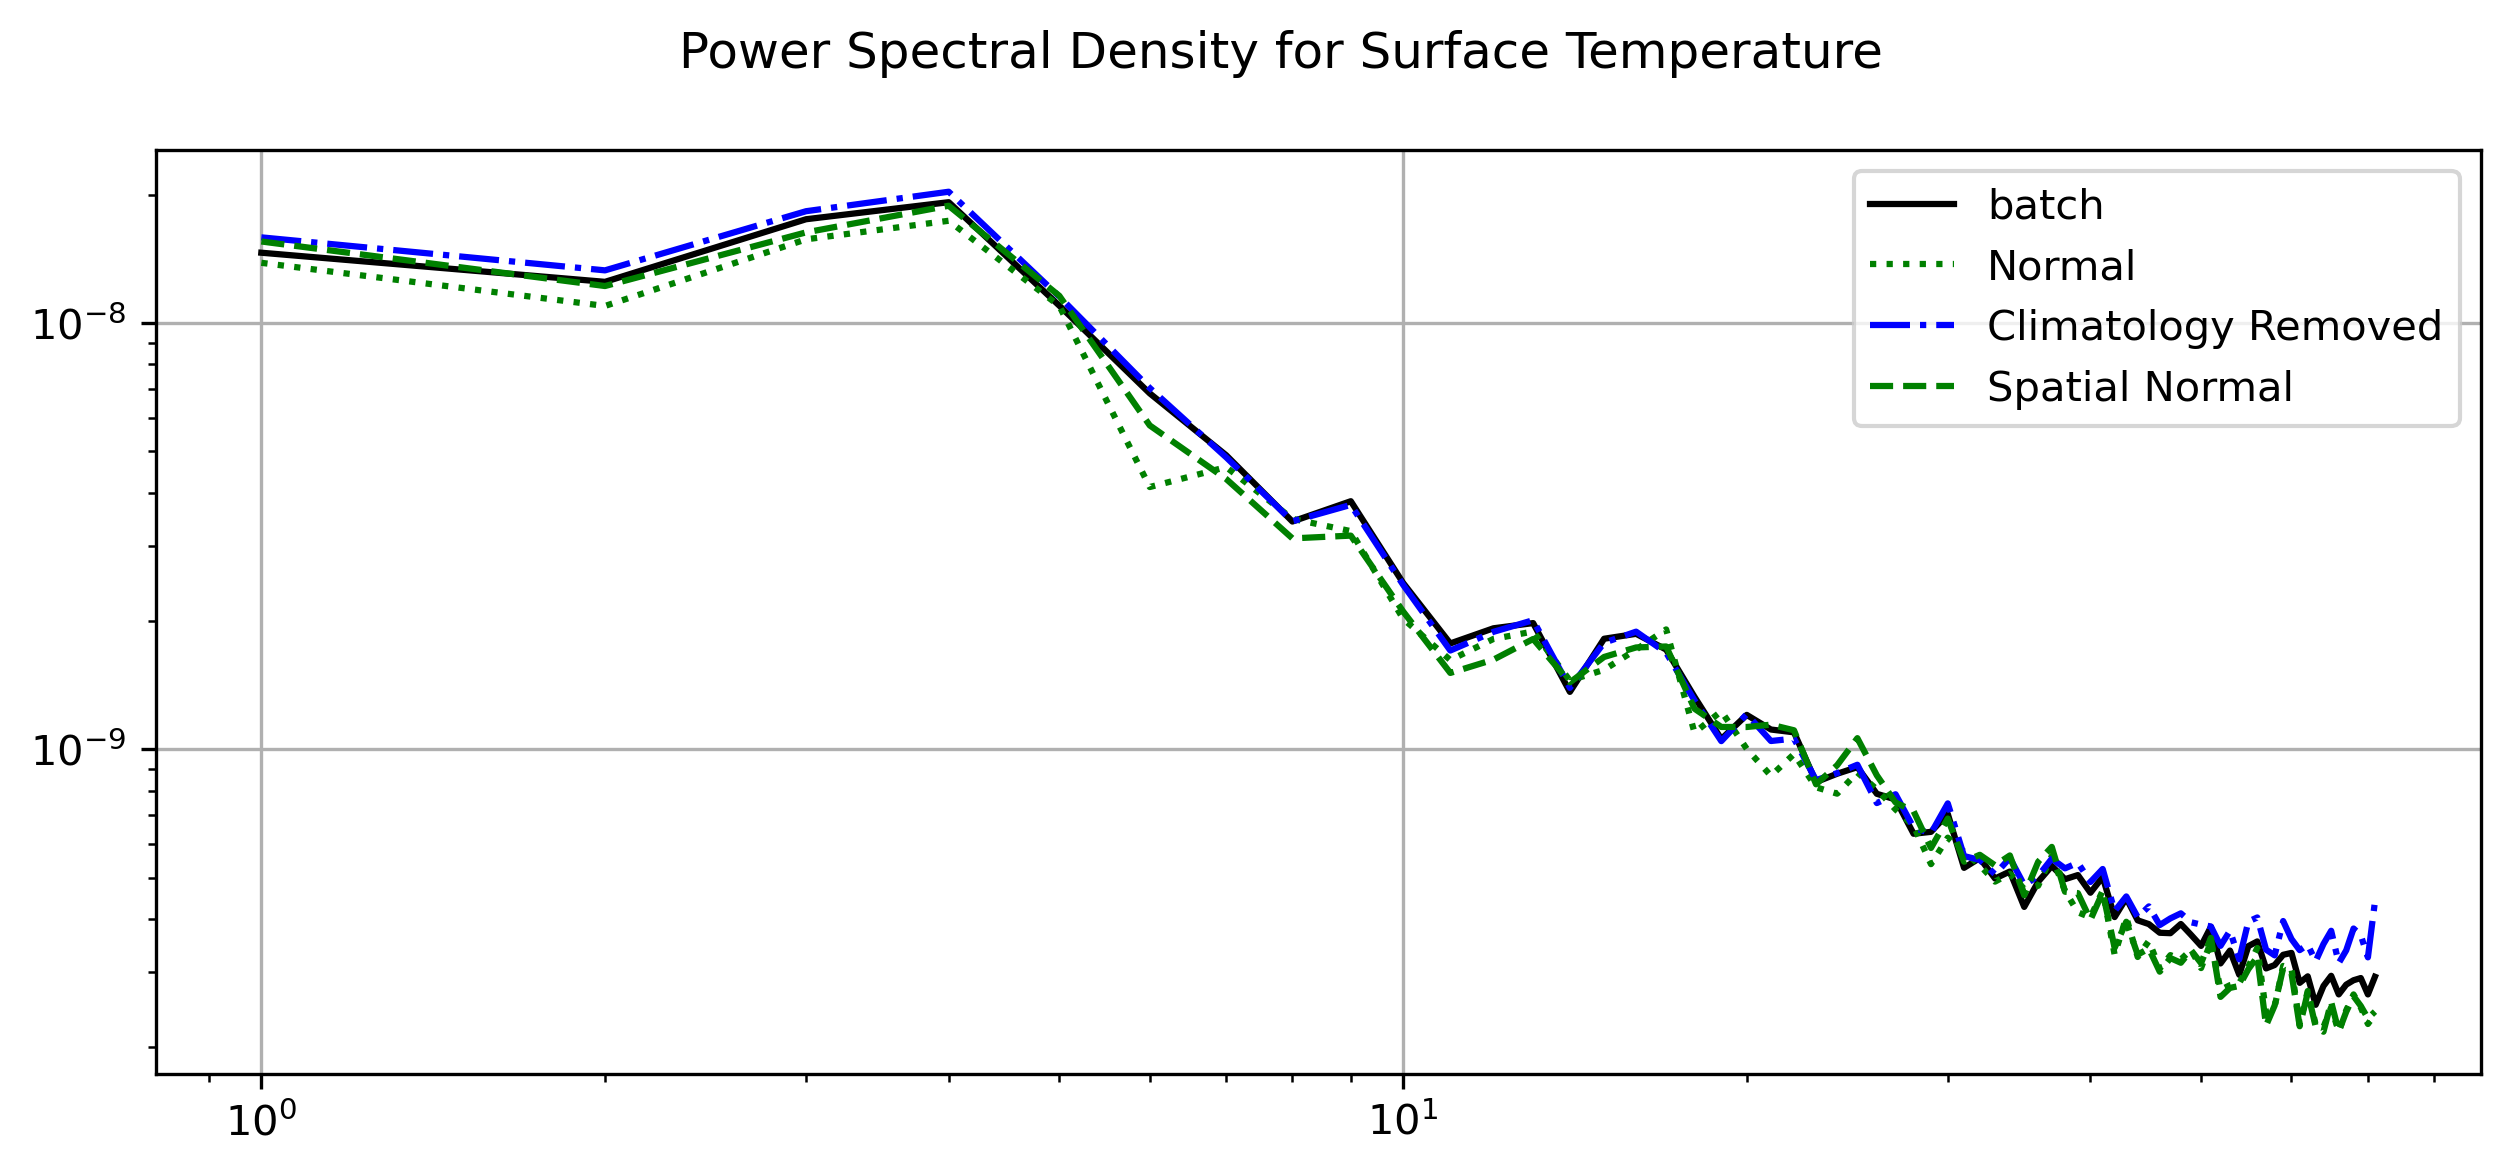

In [20]:
#get power spectra 
#from evaluation.visualization import get_power_spectral_density

   #plot power spectra
fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
fig.suptitle('Power Spectral Density for Surface Temperature')
total_psd = []
for index in range(3):
    freqs,amps = [],[]

    for step in range(0,rollout_length):
    #logfreq1, logamp1 = get_power_spectral_density(torch.where(rollouts[0][1][step]['state_constant'],rollouts[0][0][step]['next_state_surface'],torch.nan).squeeze()[var_index].squeeze())
    #logfreq2, logamp2 = get_power_spectral_density(torch.where(rollouts[0][1][step]['state_constant'],rollouts[0][1][step]['next_state_surface'],torch.nan).squeeze()[var_index].squeeze())
        logfreq, logamp = get_power_spectral_density(data1[deltas[index]][0][step]['next_state_surface'].squeeze()[var_index].squeeze())
        freqs.append(logfreq)
        amps.append(logamp)
    total_psd.append((np.stack(freqs).mean(axis=0),np.stack(amps).mean(axis=0)))

    #logfreq2, logamp2 = get_power_spectral_density(rollouts[1][1][step]['next_state_surface'].squeeze()[var_index].squeeze())
    #logfreq3, logamp3 = get_power_spectral_density(rollouts[0][0][step]['next_state_surface'].squeeze()[var_index].squeeze())

    #freqs_1.append(logfreq1)
    #amps_1.append(logamp1)
    #freqs_2.append(logfreq2)
    #amps_2.append(logamp2)
    #freqs_3.append(logfreq3)
    #amps_3.append(logamp3)
freqs,amps = [],[]

for step in range(0,rollout_length):
    logfreq, logamp = get_power_spectral_density(data1[0][1][step]['next_state_surface'].squeeze()[var_index].squeeze())
    freqs.append(logfreq)
    amps.append(logamp)
ax.loglog(np.stack(freqs).mean(axis=0),np.stack(amps).mean(axis=0),label='batch',color='black')

for index,data in enumerate(total_psd):
    ax.loglog(data[0],data[1],label=labels[index],color=colors[index],linestyle=linestyles[index])
#ax.loglog(np.stack(freqs_2).mean(axis=0),np.stack(amps_2).mean(axis=0), label='IPSL')
#ax.loglog(np.stack(freqs_3).mean(axis=0),np.stack(amps_3).mean(axis=0), label='other')

ax.grid()
ax.legend()


MovieWriter ffmpeg unavailable; using Pillow instead.


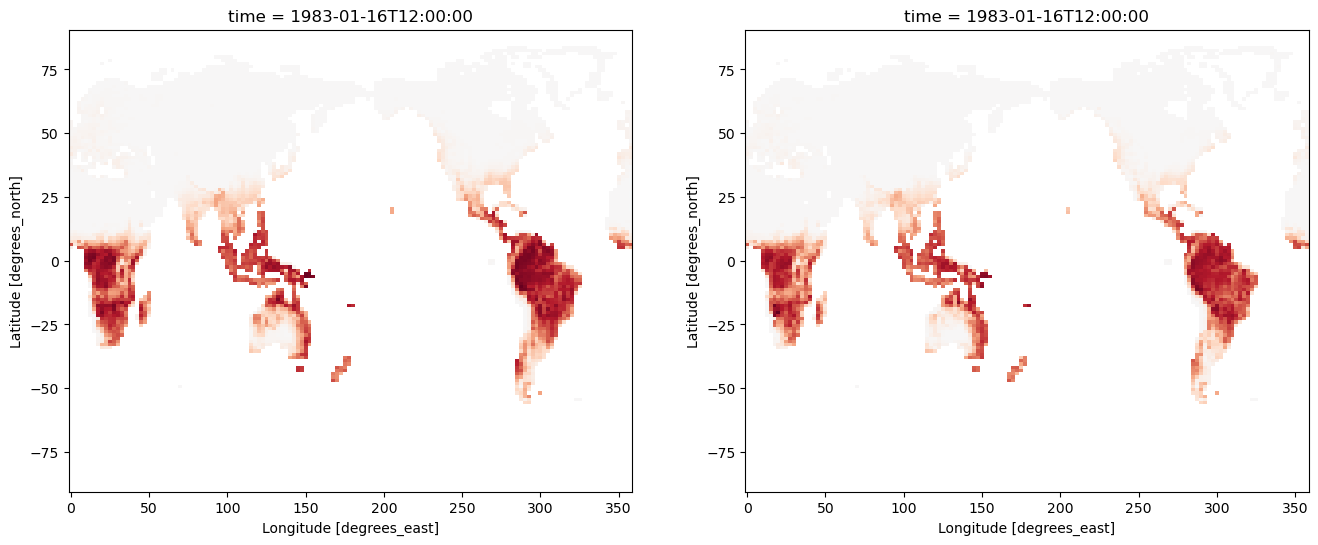

In [98]:
from evaluation.visualization import gif

rollout_for_gif = [x['next_state_surface'].squeeze()[89] for x in data1[1][0]]
rollout_for_gif_actual = [x['next_state_surface'].squeeze()[89] for x in data1[1][1]]
gif(rollout_for_gif,rollout_for_gif_actual,'gpp',test,rollout_length)

In [24]:
import glob

files = list(glob.glob(f'{scratch}/19*.nc'))

test_files = [str(x) for x in  files if any(substring in x for substring in ["_" + str(x) + '.nc'  for x in range(10,11)])]
train_files = [str(x) for x in  files if any(substring in x for substring in ["_" + str(x) + '.nc'  for x in range(1,8)])]


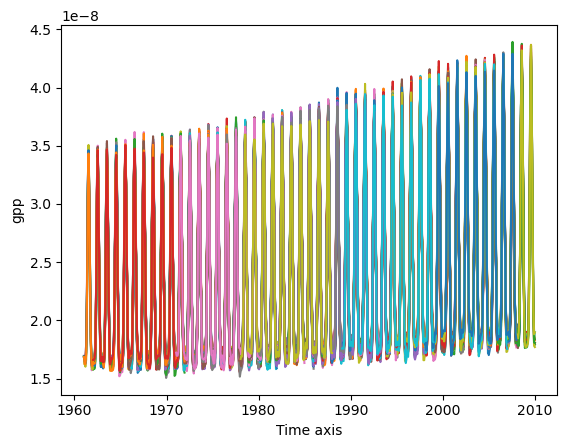

In [25]:
total_mean = []
for file in test_files:
    ds = xr.open_dataset(file)
    total_mean.append(ds['gpp'].mean(dim=('lat','lon')))
    ds['gpp'].mean(dim=('lat','lon')).plot()
for file in train_files:
    ds = xr.open_dataset(file)
    total_mean.append(ds['gpp'].mean(dim=('lat','lon')))
    ds['gpp'].mean(dim=('lat','lon')).plot()

# ds_np = np.stack(total_mean).mean(axis=0)
# adjusted_ts = []
# for file in test_files:
#     if('1961' in file):
#         ds = xr.open_dataset(file)
#         print(ds['gpp'].mean(dim=('lat','lon')).data.shape)
#         adjusted_ts.append(ds['gpp'].mean(dim=('lat','lon')).data - ds_np)

In [12]:
import os 
import numpy as np
work = os.environ['WORK']
surface_means = np.load(f'{work}/ipsl_dcpp/ipsl_dcpp/data/climatology_surface_means.npy')
surface_stds = np.broadcast_to(np.expand_dims(np.load(f'{work}/ipsl_dcpp/ipsl_dcpp/data/climatology_surface_stds.npy'),(-2,-1)),(12,91,143,144))
depth_means = np.load(f'{work}/ipsl_dcpp/ipsl_dcpp/data/climatology_depth_means.npy')
# self.depth_stds = np.load(f'{work}/data/climatology_depth_stds.npy')[:,0]
depth_stds = np.broadcast_to(np.expand_dims(np.load(f'{work}/ipsl_dcpp/ipsl_dcpp/data/climatology_depth_stds.npy'),(-2,-1)),(12,3,11,143,144))

MovieWriter ffmpeg unavailable; using Pillow instead.


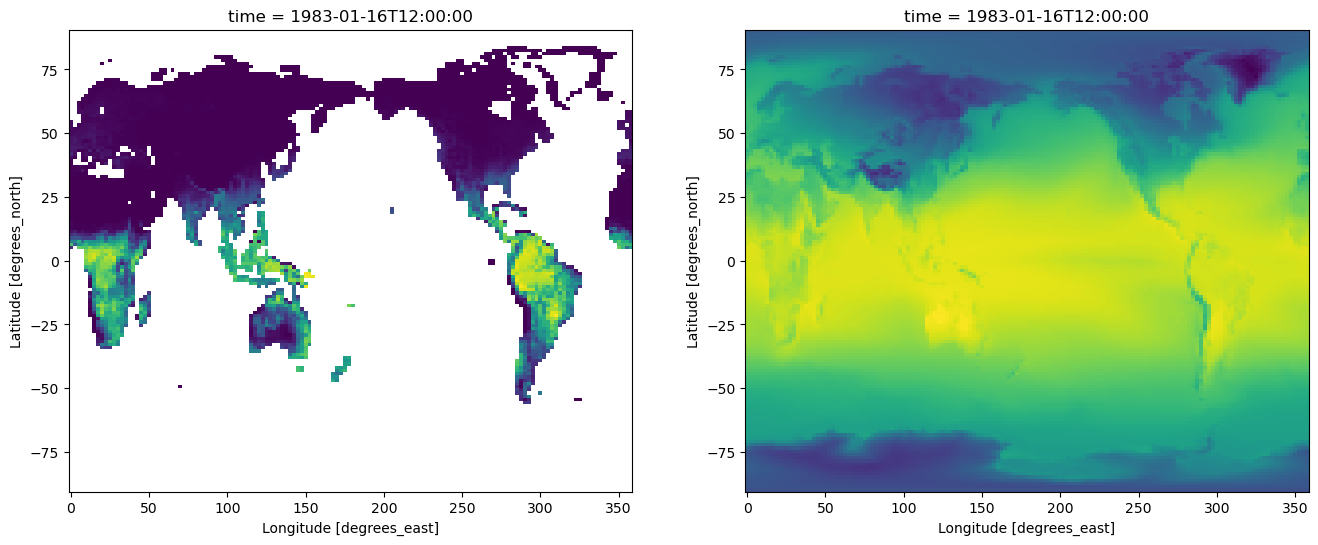

In [18]:
gif(surface_means[:,89],surface_means[:,50],'cVeg',test,12)

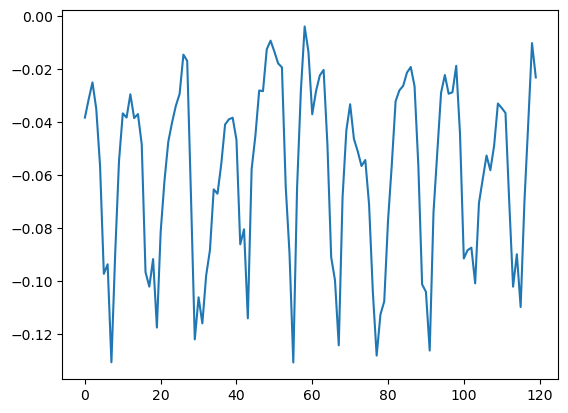

In [56]:
import matplotlib.pyplot as plt
tiled_gpp_means = np.tile(surface_means,(10,1,1,1))[:,89]
tiled_gpp_stds = np.tile(surface_stds,(10,1,1,1))[:,89]

x = np.nanmean((ds['gpp'].data - tiled_gpp_means) / tiled_gpp_stds,axis=(1,2))
plt.plot(x)

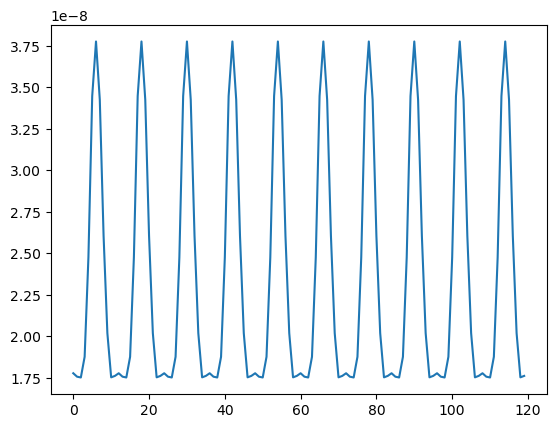

In [47]:
plt.plot(np.nanmean(np.tile(surface_means,(10,1,1,1))[:,89],axis=(1,2)))

In [46]:
np.tile(surface_means,(10,1,1,1)).shape

(120, 91, 143, 144)

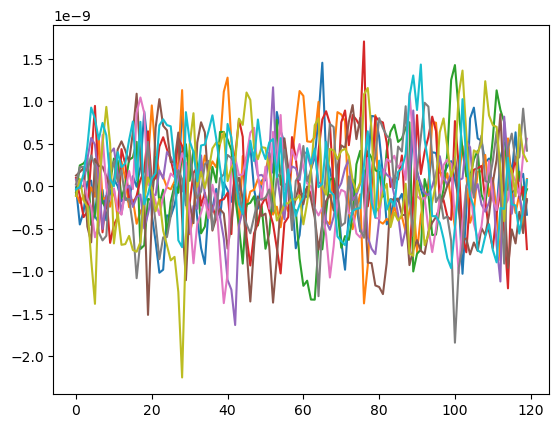

In [7]:
import matplotlib.pyplot as plt 
for i in range(10):
    plt.plot(adjusted_ts[i].T)